<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.883 · Aprendizaje por refuerzo</p>
<p style="margin: 0; text-align:right;">Máster universitario en Ciencia de datos (<i>Data science</i>)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PEC2: Deep Reinforcement Learning


En esta práctica se implementarán tres modelos de DRL en un mismo entorno, con el objetivo de analizar distintas formas de aprendizaje de un agente y estudiar su rendimiento. El agente será entrenado con los métodos:

<ol>
    <li>DQN</li>
    <li>Dueling DQN</li>
    <li>REINFORCE with baseline </li>
 </ol>

**Importante: La entrega debe hacerse en formato notebook y en formato html donde se vea el código y los resultados y comentarios de cada ejercicio. Para exportar el notebook a html puede hacerse desde el menú File  →  Download as  →  HTML.**

**Es necesario adjuntar en la entrega los ficheros .pth con los diferentes modelos entrenados.**

No es necesario adjuntar los ficheros .gif

## 0. Contexto

Uno de los objetivos más actuales del campo de la robótica es conseguir que un robot sea capaz de aprender a realizar una serie de acciones por si sólo, del mismo modo que lo hace un niño pequeño. Esta es, básicamente, una de las principales motivaciones del aprendizaje por refuerzo profundo. Para ello se necesitan sistemas de control eficientes en entornos de alta dimensionalidad como puede ser la inversión en bolsa, conducción de coches autónomos o, incluso, el control de cohetes espaciales. Con esta idea, en esta práctica usaremos un entorno ya predefinido en OpenAI, **Space Invader**.

**Space Invader** consiste en un cañón que puede disparar hacia arriba y moverse de izquierda a derecha. El objetivo del juego es destruir a los extraterrestres enemigos, que se acercan cada vez más rápido al jugador a medida que este los elimina, y maximiza la puntuación. En este entorno, la observación es una imagen RGB de la pantalla representada por una matriz de forma (210, 160, 3) cómo se observa a continuación.




![title](videos/random_agent_space_invader.gif)


Rango de acciones:
* NOOP: 0 ( No operacion).
* FIRE: 1 (disparar sin moverse)
* RIGHT: 2 (mover a la derecha)
* LEFT: 3 (mover a la izquierda)
* RIGHTFIRE: 4 (disparar y mover a la derecha)
* LEFTFIRE: 5 (disparar y mover a la izquierda)


Recompensa: La recompensa devuelta por el entorno está compuesta por un valor en el rango [0, 30]. Dependiendo de la nave alienígena destruida, el agente recibe una puntuación diferente.
 Nuestra tarea es enseñarle una política que le permita hacer una elección "buena" para cada estado.

Para más detalles sobre la definición del entorno de Space Invader, se recomienda consultar las web: <href>https://www.gymlibrary.dev/environments/atari/space_invaders/</href> y  <href>https://atariage.com/manual_html_page.php?SoftwareLabelID=460</href>


## 1. Inicialización y exploración del entorno (1 pto)
**IMPORTANTE**: el entorno Space Invader depende de la instalación de los siguientes paquetes
<ul>
     <li>gym[atari] en la versión 0.25.0</li>
     <li>autorom[accept-rom-license]</li>
</ul>

Este entorno puede ser ejecutado tanto en local como en Kaggle con la versión de GPU P100 y en Google Colab. Recomiendo utlizar Kaggle para los estudiantes que no dispongan de una GPU en local.

Empezaremos cargando las principales librerías necesarias para la práctica:


In [1]:
#instalación de librerías.
import warnings
warnings.filterwarnings('ignore')
import time
!pip install gym[atari]==0.25.0
!pip install autorom[accept-rom-license]
!pip install imageio
!pip install matplotlib
import gym
import torch
import matplotlib.pyplot as plt
from ale_py import ALEInterface
ale = ALEInterface()
from ale_py.roms import SpaceInvaders
ale.loadROM(SpaceInvaders)
import numpy as np
import os
import imageio
from PIL import Image
import PIL.ImageDraw as ImageDraw
!pip install scikit-image
from skimage import transform
import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 720.4/720.4 kB 11.5 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 45.4 MB/s eta 0:00:00
  Created wheel for gym: filename=gym-0.25.0-py3-none-any.whl size=824411 sha256=f66c389124c698a60e2bff5bfb222399262392c47d5d956b1be16e469128fc38
  Stored in directory: /root/.cache/pip/wheels/2c/58/d8/1590abcfe48cdf414681b1e2b6647045b85f7c924563b664ee
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.26.2
    Uninstalling gym-0.26.2:
      Successfully uninstalled gym-0.26.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 52.8 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for AutoROM.accept-rom-license: filen

A.L.E: Arcade Learning Environment (version 0.7.5+db37282)
[Powered by Stella]
Game console created:
  ROM file:  /opt/conda/lib/python3.7/site-packages/AutoROM/roms/space_invaders.bin
  Cart Name: Space Invaders (1978) (Atari) [!]
  Cart MD5:  72ffbef6504b75e69ee1045af9075f66
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        4096
  Bankswitch Type: AUTO-DETECT ==> 4K

Running ROM file...
Random seed is 1671281088


In [2]:
# Comprobación de la versión de GYM instalada
print('La versión de gym instalada: ' + gym.__version__)
# Comprobación de entorno con gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("El entorno utiliza: ", device)

La versión de gym instalada: 0.25.0
El entorno utiliza:  cuda



Comprueba que la celda anterior indica que la versión instalada de Gym es la 0.25.0.


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 1.1 (0.2 ptos):</strong> Inicializar el entorno 'SpaceInvaders-v4'. Extraer:
<ul>
 <li> Valor del umbral de recompensa definido en el entorno</li>
 <li> Máximo número de pasos establecidos para cada episodio</li>
 <li> La dimensión del espacio de acciones</li>
 <li> La dimensión del espacio de observaciones.</li>
 </ul>
</div>


In [3]:
warnings.filterwarnings('ignore')
env = gym.make('SpaceInvaders-v4')

print("El rango de recompensas es {} ".format(env.reward_range))
print("El valor umbral de recompensa es {} ".format(env.spec.reward_threshold))
print("El máximo número de pasos para cada episodio es {} ".format(env.spec.max_episode_steps))
print("La dimensión del espacio de acciones es {} ".format(env.action_space))
print("La dimensión del espacio de observaciones es {} ".format(env.observation_space))

El rango de recompensas es (-inf, inf) 
El valor umbral de recompensa es None 
El máximo número de pasos para cada episodio es 100000 
La dimensión del espacio de acciones es Discrete(6) 
La dimensión del espacio de observaciones es Box(0, 255, (210, 160, 3), uint8) 


A.L.E: Arcade Learning Environment (version 0.7.5+db37282)
[Powered by Stella]


En el aprendizaje por refuerzo suele ser muy útil visualizar el comportamiento de un agente en su entorno. Para esta PEC es interesante poder almacenar el comportamiento visual de un agente en forma de archivo .gif.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 1.2 (0.2 ptos):</strong>  En este ejericicio os proponemos almacenar en una carpeta videos un ejemplo de actuación del agente aleatorio en forma de archivo .gif.

    -----------------------------------------------------------------------------------------------------------
    
<b>Nota</b>: se os proporciona el código pre-implementado. La implementación que se pide en el enunciado está indicada en los bloques <i>TODO</i> y/o con variables igualadas a <i>None</i>.
</div>


In [4]:
#Método para generar la imagen a partir de un estado con un texto informativo.
def _label_with_text(frame):
    '''
    frame: estado de un entorno GYM.
    '''
    im = Image.fromarray(frame)
    im = im.resize((im.size[0]*2,im.size[1]*2))
    drawer = ImageDraw.Draw(im)
    drawer.text((1, 1), "Uoc Aprendizaje Por Refuerzo.", fill=(255, 255, 255, 128))
    return im

#Método que permite crear un gif con la evolución de una partida dado un entorno GYM.
def save_random_agent_gif(env):
    
    frames = []
    done = False
    env.reset()

    while not done:
        action = env.action_space.sample()
        frame = env.render(mode='rgb_array')
        frames.append(_label_with_text(frame))
        state, _, done, _ = env.step(action)

    env.close()
    imageio.mimwrite(os.path.join('./videos/', 'random_agent_space_invader_usuario.gif'), frames, fps=60)

In [5]:
env = gym.make('SpaceInvaders-v4', render_mode='rgb_array')
try:
    os.makedirs('videos')
except:
    pass
save_random_agent_gif(env)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 1.3 (0.3 ptos):</strong> Ejecutar 1000 episodios con el máximo de pasos establecido en el entorno de Space Invader, tomando acciones de forma aleatoria. Almacenar la suma de recompensas de cada partida y la cantidad de episodios ejecutados. Mostrar:
    <ul>
       <li>Histograma con la suma de recompensas de cada partida</li>
       <li>Histograma con la cantidad de pasos para resolver cada partida. </li>
    </ul>
</div>

In [6]:
def random_policy(done, state):
    
    game_rewards = 0
    game_steps = 0
    
    while not done:
        action = env.action_space.sample()
        new_state, reward, done, _ = env.step(action)
        state = new_state
        game_rewards += reward
        game_steps += 1
    
    env.close()
    rewards.append(game_rewards)
    steps.append(game_steps)

def play_games(env, policy, games):
    
    played_games = 0

    while played_games < games:
        done = False
        state = env.reset()
        policy(done, state)
        played_games += 1

In [7]:
env = gym.make('SpaceInvaders-v4')

games = 1000
rewards = []
steps = []

play_games(env, random_policy, games)

In [8]:
def plot_histogram(data, title):
    
    n, bins, patches = plt.hist(x=data, bins='auto', rwidth=0.85)
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('Valor')
    plt.ylabel('Frecuencia')
    plt.title(title)

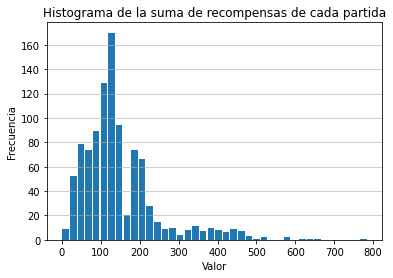

In [9]:
plot_histogram(rewards, 'Histograma de la suma de recompensas de cada partida')

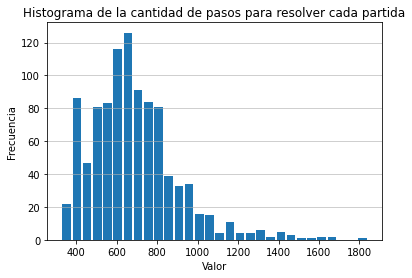

In [10]:
plot_histogram(steps, 'Histograma de la cantidad de pasos para resolver cada partida')

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis (0.3 ptos):</strong> ¿Cuál es la media de recompensas obtenida? ¿Y la media de pasos por episodio? Comenta los resultados obtenidos.
</div>

In [11]:
rewards_mean = sum(rewards)/len(rewards)
steps_mean = sum(steps)/len(steps)
print("La media de recompensas obtenida es {} ".format(rewards_mean))
print("La media de pasos por episodio es {} ".format(steps_mean))

La media de recompensas obtenida es 147.465 
La media de pasos por episodio es 684.691 


<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Solución:</strong>
<br>Podemos ver que la media de recompensas obtenida tras ejecutar 1000 episodios con el máximo de pasos establecido en el entorno de Space Invader, tomando acciones de forma aleatoria es de alrededor de 148 y la media de pasos es aproximadamente de  685 pasos.
    Las distribuciones de los datos parecen aproximarese a la normal aunque hay algunos valores estremos es sus colas derechas.
    Parecen resultados relativamente buenos para tratarse de acciones aleatorias.<br>
</div>

## 2. Agente DQN (2.8 ptos)
En este apartado implementaremos una solución DQN para intentar obtener un modelo que nos permita solucionar este entorno. Primeramente definiremos el modelo de red neuronal, luego describiremos el comportamiento del agente, lo entrenaremos y, finalmente, testearemos el funcionamiento del agente entrenado.


### 2.1 Procesamiento de las observaciones.


El primer paso es entender la estructura de la información que nos proporciona el entorno. Los juegos de Atari utilizan un espacio de acción con una estructura de la siguiente forma (210, 160, 3), es decir, 210 pixeles de anchura, 160 de altura y 3 colores (RGB). Cada uno de estos puntos de la estructura es un pixel de color y posee un rango de valores que van desde el 0 hasta 255, lo que nos da $256^{(210x160x3)}$ = $256^{100800}$ posibilidades (a modo de comparación, tenemos aproximadamente $10^{80}$ átomos en el universo observable)

<p></p>
<img src="imagenes/atomos.jpg"  width="1000">

Fuente: <href>https://huggingface.co/blog/deep-rl-dqn</href>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>2.1 Análisis (0.2 pto):</strong> ¿Es posible implementar una solución tabular vista durante la PEC1 en este entorno de Space Invader?
</div>

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Respuesta:</strong>
<br>En este entorno de Space Invader el espacio de estados es demasiado grande para poder representarlo en una tabla, por tanto, no sería en absoluto eficiente implementar una solución tabular como las vistas durante la PEC1. Podremos implementar soluciones aproximadas a través de estimadores de función, utilizando el aprendizaje por refuerzo profundo y las redes neuronales. <br>
</div>

En este caso, la mejor idea es, dado un estado, aproximar los valores Q para cada posible acción en ese estado. Es decir, implementaremos la solución que puedes observar en la siguiente figura.

<p></p>
<img src="imagenes/deep.jpg"  width="1000">

Fuente: <href>https://huggingface.co/blog/deep-rl-dqn</href>

<p></p>

Ahora bien, en el juego Space Invader no todo el espacio posee utilidad. El marcador, el marco o la cantidad de vidas no es necesario para el desarrollo del juego. Una práctica muy habitual en el aprendizaje por refuerzo es reducir las dimensiones del entorno con el objetivo de disminuir la cantidad de cálculos necesarios para obtener un modelo útil para el entorno.

Exactamente, para esta PEC os vamos a pedir reducir el espacio de los frames a 84 x 84 píxeles, reducir nuestros tres canales de color (RGB) a 1 (blanco y negro), normalizar el resultado y, por último, almacenar los 4 últimos frames cómo se muestra en la siguiente figura:
<p></p>
<img src="imagenes/preprocessing.jpg"  width="1000">

Fuente: <href>https://huggingface.co/blog/deep-rl-dqn</href>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 2.2  (0.1 pto):</strong> Define el metodo scale_lumininance para, dado un estado, transformar los puntos del sistema RGB al sistema binario blanco y negro
</div>

In [12]:
state = env.reset()

In [13]:
def scale_lumininance(obs):
    
    original_image = Image.fromarray(obs)
    gray_image = original_image.convert('L')
    
    return np.array(gray_image)

(210, 160)


Text(0.5, 1.0, 'Grayscale')

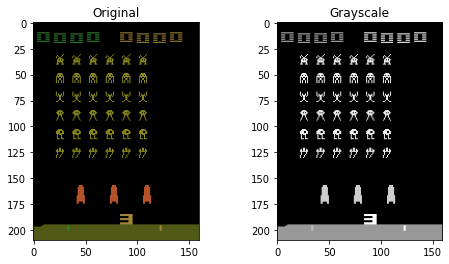

In [14]:
obs = scale_lumininance(state)
print(obs.shape)
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax = axes.ravel()
ax[0].imshow(state)
ax[0].set_title("Original")
ax[1].imshow(obs, cmap=plt.cm.gray)
ax[1].set_title("Grayscale")

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 2.3 (0.1 pto):</strong> Define el metodo resize para, dado un estado, redimensionar su tamaño a 84 * 84
</div>

In [15]:
def resize(obs):
    
    original_image = Image.fromarray(obs)
    resized_image = original_image.resize((84, 84))
    
    return np.array(resized_image)

(84, 84)


Text(0.5, 1.0, 'Grayscale resized')

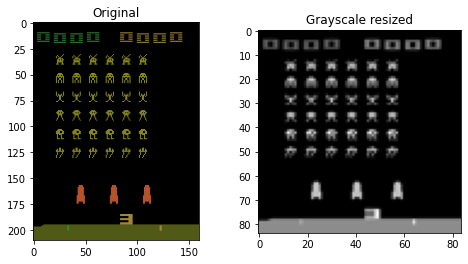

In [16]:
obs = resize(obs)
print(obs.shape)
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax = axes.ravel()
ax[0].imshow(state)
ax[0].set_title("Original")
ax[1].imshow(obs, cmap=plt.cm.gray)
ax[1].set_title("Grayscale resized")

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>2.4 Ejercicio (0.1 pto):</strong> Define el metodo normalize para, dado un estado, normalice la imagen
</div>

In [17]:
def normalize(obs):
    
    original_array = obs
    norm_image = original_array/255
    norm_image = np.array(norm_image)
    norm_image = norm_image.reshape(1, * norm_image.shape)
    
    return norm_image

(1, 84, 84)


Text(0.5, 1.0, 'Grayscale resized normalized')

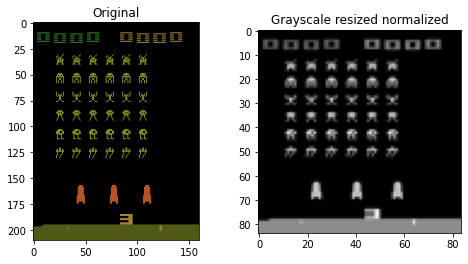

In [18]:
obs = normalize(obs)
print(obs.shape)
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax = axes.ravel()
ax[0].imshow(state)
ax[0].set_title("Original")
ax[1].imshow(obs.reshape([84,84,1]), cmap=plt.cm.gray)
ax[1].set_title("Grayscale resized normalized")

El resultado que vas a obtener será el siguiente:


Los resultados obtenidos para cada una de las funciones que hemos definido se parecen mucho a esas imágenes.

In [19]:
env.render(mode='rgb_array')
action = env.action_space.sample()
state, reward, done, _ = env.step(action)

# Función que realiza todo el pre-procesado de una observación
def preprocess_observation(obs):
    
    obs_proc = scale_lumininance(obs)
    obs_proc = resize(obs_proc)
    obs_proc = normalize(obs_proc)
    
    return obs_proc

(1, 84, 84)


Text(0.5, 1.0, 'Grayscale resized normalized')

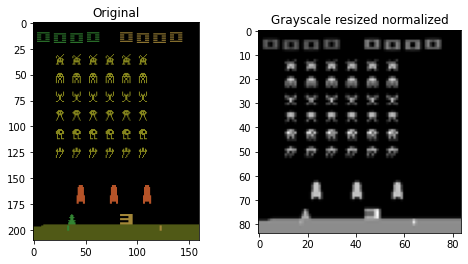

In [20]:
obs = preprocess_observation(state)
print(obs.shape)
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax = axes.ravel()
ax[0].imshow(state)
ax[0].set_title("Original")
ax[1].imshow(obs.reshape([84,84,1]), cmap=plt.cm.gray)
ax[1].set_title("Grayscale resized normalized")

Por último, ¿cómo interpretamos el movimiento? Las imágenes corresponden a información estática de las partidas y, en este entorno, es importante conocer la dirección del disparo o el movimiento de los invasores. Para ello, una forma de gestionar esta información es apilando fotogramas para poder proporcionar al algoritmo información acerca de la progresión de la partida.


Utilicemos un ejemplo muy claro, el Ping Pong:

Fíjate cómo la pelota se desplaza hacia la derecha. La agrupación de los frames nos permite trasladar la información espacial a nuestro algoritmo.



<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 2.5  (0.1 ptos):</strong> Implementa la función stack_frame para apilar 4 frames de una partida. Dicha función debe apilar inicialmente (cuando is_new = True) el mismo frame 4  veces para, posteriormente, conforme se vayan introduciendo nuevos frames ir substituyendo a los más antiguos.
</div>

In [21]:
def stack_frame(stacked_frames, frame, is_new):
    """Stacking Frames.
    Params
    ======
        stacked_frames (array): array de frames (al devolverlo debe tener 4 frames)
        frame: Nueva imagen a añadir (hay que borrar la más antigua)
        is_new: Primera vez que se utiliza el array.
    """
    frame = frame.reshape([84,84])
    
    if is_new:
        stacked_frames = np.stack((frame, frame, frame, frame))

    else:
        second = stacked_frames[1]
        third = stacked_frames[2]
        fourth = stacked_frames[3]
        stacked_frames = np.stack((second, third, fourth, frame))
    
    return stacked_frames

Una vez creada la función la testeamos jugando una partida, almacenando los 4 frames más recientes en cada paso, y finalmente mostramos los 4 últimos frames de la partida.

state_stack (4, 84, 84)


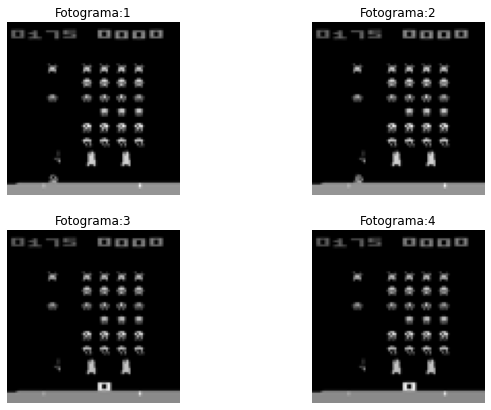

In [22]:
# Llenamos 'state_stack' con 4 copias idénticas del frame inicial de la partida
# Lo hacemos con el frame preprocesado, para visualizar los frames "reales" utilizados en la red
state_stack = stack_frame(None, preprocess_observation(env.reset()), True)

# Jugamos una partida aleatoria y vamos actualizando los 4 frames de 'state_stack'
# conforme se van produciendo nuevos
while True:
    action = env.action_space.sample()
    next_state, reward, done, info = env.step(action)
    state_stack = stack_frame(state_stack, preprocess_observation(next_state), False)

    if done:
         break

# Mostramos los últimos 4 frames de la partida que han quedado almacenados en 'state_stack'
fig = plt.figure(figsize=(10, 7))
rows = 2
columns = 2
cont=1
print('state_stack',state_stack.shape)

for i in state_stack:
    #print('i',i.shape)
    fig.add_subplot(rows, columns, cont)
    plt.imshow(i.reshape([84,84,1]), cmap=plt.cm.gray)
    plt.axis('off')
    plt.title('Fotograma:' + str(cont))
    cont = cont +1

El test ha funcionado correctamente: vemos los cuatro últimos frames de la partida, en los que vemos que el bot ha obtenido una puntuación de 175 puntos y cómo termina desapareciendo de la escena.

Ahora con estas modificaciones podemos pasar al siguiente punto, la creación de la Red
<p></p>
<img src="imagenes/deep-q-network.jpg"  width="1000">

Fuente: <href>https://huggingface.co/blog/deep-rl-dqn</href>

Cómo se observa en la imagen, utilizaremos un modelo convolucional (perfecto para detectar patrones en imágenes) junto con un sistema lineal completamente conectado. Para la red convolucional os proponemos la siguiente configuración:

<ul>
    <li>Una primera capa del tipo Conv2d con los siguientes parámetros in_channels=4, out_channels=32, kernel_size=8, stride=4 con activación ReLU.</li>
    <li>Una segunda capa del tipo Conv2d con los siguientes parámetros in_channels=32, out_channels=64, kernel_size=4, stride=2 con activación ReLU.</li>
    <li>Una tercera capa del tipo Conv2d con los siguientes parámetros in_channels=64, out_channels=64, kernel_size=3, stride=1 con activación ReLU.</li>
</ul>

El resultado de esta primera red (3D) lo conectaremos con un modelo complementamente conectado (1D) con la siguiente estructura lineal:

* Una primera capa completamente conectada (representada en pytorch por nn.Lineal) de 512 neuronas, con activación ReLU
* Una última capa completamente conectada. Esta será nuestra capa de salida y, por lo tanto, tendrá tantas neuronas como dimensiones tenga nuestro espacio de acciones (una salida por cada acción posible).

Por último, usaremos el optimizador Adam para entrenar la red.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Ejercicio 2.6 (0.5 ptos):</strong>Implementar la clase  <code>DQN_CNN()</code>. Inicializar las variables necesarias y definir el modelo CNN y linial indicado.

    -----------------------------------------------------------------------------------------------------------
<b>Nota</b>: se os proporciona el código pre-implementado. La implementación que se pide en el enunciado está indicada en los bloques <i>TODO</i> y/o con variables igualadas a <i>None</i>.

</div>

In [23]:
import torch.nn as nn

class DQN_CNN(nn.Module):
    
    def __init__(self, env, learning_rate=1e-3):
        
        super(DQN_CNN, self).__init__()
        """
        Params
        ======
        n_inputs: tamaño del espacio de estados
        n_outputs: tamaño del espacio de acciones
        actions: array de acciones posibles
        device: cpu o cuda
        red_cnn: definición de la red convolucional
        red_lineal: definición de la red lineal
        """
        #######################################
        ###TODO: inicialización y modelo###
        self.input_shape = (4, 84, 84)
        self.n_outputs = env.action_space.n
        self.actions = list(range(0,6))
        
        if torch.cuda.is_available():
            self.device = 'cuda'
        else:
            self.device = 'cpu'

        #######################################
        ##TODO: Construcción de la red neuronal convolucional
        self.red_cnn = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        if torch.cuda.is_available():
            self.red_cnn.cuda()
        
        self.fc_layer_inputs = self.feature_size() # Usar como entrada de la otra red
        #######################################
        ##TODO: Construcción de la red neuronal lineal completamente conectada
        self.red_lineal = nn.Sequential(
            nn.Linear(3136, 512), #self.fc_layer_inputs
            nn.ReLU(),
            nn.Linear(512, self.n_outputs)
        )

        if torch.cuda.is_available():
            self.red_lineal.cuda()

        #######################################
        ##TODO: Inicializar el optimizador#####
        self.optimizer = optim.Adam(self.parameters(), lr = learning_rate)

    ### e-greedy method
    def get_action(self, state, epsilon=0.05):
        
        if np.random.random() < epsilon:
            action = np.random.choice(self.actions)
        else:
            qvals = self.get_qvals(state)
            action = torch.max(qvals, dim=-1)[1].item()
        
        return action
    
    def get_qvals(self, state):
        
        if type(state) is tuple:
            state = np.array(state)
        state_t = torch.FloatTensor(state).to(device=self.device)
        cnn_out = self.red_cnn(state_t).reshape(-1,  self.fc_layer_inputs)
        
        return self.red_lineal(cnn_out)
    
    def feature_size(self):
        
        return self.red_cnn(autograd.Variable(torch.zeros(1, *self.input_shape)).to(device=self.device)).view(1, -1).size(1)

Definimos la clase para el *buffer* de repetición de experiencias:


In [24]:
from collections import namedtuple, deque

class experienceReplayBuffer:
    
    def __init__(self, memory_size=50000, burn_in=10000):
        
        self.memory_size = memory_size
        self.burn_in = burn_in
        self.buffer = namedtuple('Buffer',
            field_names=['state', 'action', 'reward', 'done', 'next_state'])
        self.replay_memory = deque(maxlen=memory_size)

    def sample_batch(self, batch_size=32):
        
        samples = np.random.choice(len(self.replay_memory), batch_size,
                                   replace=False)
        # Use el operador asterisco para desempaquetar deque
        batch = zip(*[self.replay_memory[i] for i in samples])
        
        return batch

    def append(self, state, action, reward, done, next_state):
        
        self.replay_memory.append(
            self.buffer(state, action, reward, done, next_state))

    def burn_in_capacity(self):
        
        return len(self.replay_memory) / self.burn_in

### 2.2 Definición del agente


A continuación implementaremos una clase que defina el entrenamiento del agente teniendo en cuenta:
    <ul>
        <li>La exploración/explotación (decaimiento de epsilon)</li>
        <li>La actualización y sincronización de la red principal y la red objetivo (pérdida)</li>
    </ul>

Además, vamos a considerar que el agente ha superado el entorno cuando obtenga una puntuación superior a 350 en 100 partidas

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 2.7 (1 pto):</strong> Implementar los siguientes puntos de la clase <code>DQNAgent()</code>:
    <ol>
        <li>Declarar las variables de la clase</li>
        <li>Inicializar las variables necesarias</li>
        <li>Implementar la acción a tomar</li>
        <li>Actualizar la red principal según la frecuencia establecida en los hiperparámetros</li>
        <li>Calcular la ecuación de Bellman</li>
        <li>Sincronizar la red objetivo según la frecuencia establecida en los hiperparámetros</li>
        <li>Calcular la media de recompensas de los últimos 100 episodios</li>
        <li>Actualizar epsilon según: $$\textrm{max}(\epsilon · \epsilon_{\textrm{decay}}, 0.01)$$ </li>
    </ol>
Además, durante el proceso se deben almacenar (*):
    <ul>
        <li>Las recompensas obtenidas en cada paso del entrenamiento</li>
        <li>Las recompensas medias de los 100 episodios anteriores</li>
        <li>La pérdida durante el entrenamiento</li>
        <li>La evolución de epsilon a lo largo del entrenamiento</li>
    </ul>

    -----------------------------------------------------------------------------------------------------------
<b>Nota</b>: se os proporciona el código pre-implementado. La implementación que se pide en el enunciado está indicada en los bloques <i>TODO</i> y/o con variables igualadas a <i>None</i>, salvo (*) en qué momento almacenar las variables que se indican.
</div>

In [25]:
from copy import deepcopy, copy

class DQNAgent:
    
    ###################################################
    ######TODO 1: declarar variables ##################
    def __init__(self, env, main_network,
                 buffer, reward_threshold=350,
                 epsilon=0.1, eps_decay=0.99, batch_size=32, nblock=100):
        """"
        Params
        ======
        env: entorno
        main_network: clase con la red neuronal diseñada
        target_network: red objetivo
        buffer: clase con el buffer de repetición de experiencias
        epsilon: epsilon
        eps_decay: epsilon decay
        batch_size: batch size
        nblock: bloque de los X últimos episodios de los que se calculará la media de recompensa
        reward_threshold: umbral de recompensa
        """
        
        if torch.cuda.is_available():
            self.device = 'cuda'
        else:
            self.device = 'cpu'
        
        self.env = env
        self.main_network = main_network
        self.target_network = deepcopy(main_network) # red objetivo (copia de la principal)
        self.buffer = buffer
        self.epsilon = epsilon
        self.eps_decay = eps_decay
        self.batch_size = batch_size
        self.nblock = nblock # bloque de los X últimos episodios para calcular la media de recompensa
        self.reward_threshold = reward_threshold # el agente supera el entorno si obtiene una puntuación superior a 350 en 100 partidas
        self.initialize()

    ###############################################################
    #####TODO 2: inicializar variables extra que se necesiten######
    def initialize(self):
        
        self.sync_eps = []
        self.total_reward = 0
        self.loss = 0
        self.step_count = 0
        inicio_juego = preprocess_observation(self.env.reset())
        self.state0 = stack_frame(None, inicio_juego, True)
        
        self.train_rewards = []
        self.train_mean_rewards = []
        self.train_loss = []
        self.eps_evolution = []
        self.update_loss = []

    #################################################################################
    ######TODO 3: Tomar nueva acción ################################################
    def take_step(self, eps, mode='train'):
        
        if mode == 'explore':
            action = self.env.action_space.sample()  # acción aleatoria en el burn-in
        else:
            action = self.main_network.get_action(self.state0, eps)# acción a partir del valor de Q (elección de la acción con mejor Q)
            self.step_count += 1
        
        #TODO: Realización de la acción y obtención del nuevo estado y la recompensa.
        new_state, reward, done, _ = env.step(action) # Realizar acción --> nuevo estado, recompensa, done?
        new_state = preprocess_observation(new_state) # Recordar preprocesar los estados
        new_state = stack_frame(self.state0, new_state, False)
        self.total_reward += reward # Añadir recompensa
        self.buffer.append(self.state0, action, reward, done, new_state) # Guardar experiencia en el buffer
        self.state0 = new_state
        
        #TODO: resetear entorno 'if done'
        if done:
            inicio_juego = preprocess_observation(self.env.reset())
            self.state0 = stack_frame(None, inicio_juego, True) # Recordar preprocesar los estados
        
        return done



    ## Entrenamiento
    def train(self, gamma=0.99, max_episodes=50000,
              batch_size=32,
              dnn_update_frequency=4,
              dnn_sync_frequency=2000, min_episodios=250, min_epsilon = 0.01):
        
        self.gamma = gamma
        # Rellenamos el buffer con N experiencias aleatorias ()
        print("Filling replay buffer...")
        
        while self.buffer.burn_in_capacity() < 1:
            self.take_step(self.epsilon, mode='explore')

        episode = 0
        training = True
        print("Training...")
        maximo = 0
        
        while training:
            self.state0 = stack_frame(None, preprocess_observation(self.env.reset()), True) # Recordar preprocesar los estados
            self.total_reward = 0
            self.loss = 0
            gamedone = False
            
            while gamedone == False:
                # El agente toma una acción
                gamedone = self.take_step(self.epsilon, mode='train')

                #################################################################################
                ###TODO 4: Actualizar red principal según la frecuencia establecida##############
                if self.step_count % dnn_update_frequency == 0:
                    self.update()

                ########################################################################################
                ###TODO 6: Sincronizar red principal y red objetivo según la frecuencia establecida#####
                if self.step_count % dnn_sync_frequency == 0:
                    self.target_network.load_state_dict(self.main_network.state_dict())
                    self.sync_eps.append(episode)

                if gamedone:
                    episode += 1
                    ##################################################################
                    ########TODO: Almacenar epsilon, training rewards y loss##########
                    self.eps_evolution.append(self.epsilon)
                    self.train_rewards.append(self.total_reward)
                    self.train_loss.append(self.loss.detach().to('cpu').numpy())
                    
                    ##################################################################
                    
                    self.update_loss = []


                    #######################################################################################
                    ###TODO 7: Calcular la media de recompensa de los últimos X episodios, y almacenar#####
                    mean_rewards = np.mean(self.train_rewards[-self.nblock:])
                    self.train_mean_rewards.append(mean_rewards)
                    maximo = max(self.train_mean_rewards)
                    
                    ##################################################################

                    print("\rEpisode {:d} Mean Rewards {:.2f} Epsilon {} , Maximo {:.2f}\t\t".format(
                        episode, mean_rewards, self.epsilon,maximo), end="")

                    # Comprobar si se ha llegado al máximo de episodios
                    if episode >= max_episodes:
                        training = False
                        print('\nEpisode limit reached.')
                        break

                    # Termina el juego si la media de recompensas ha llegado al umbral fijado para este juego
                    # y se ha entrenado un mínimo de episodios
                    if mean_rewards >= self.reward_threshold and min_episodios <  episode:
                        training = False
                        print('\nEnvironment solved in {} episodes!'.format(
                            episode))
                        break

                    #################################################################################
                    ######TODO 8: Actualizar epsilon ################################################
                    self.epsilon = max(self.epsilon * eps_decay, min_epsilon)


    #######################################
    #####TODO 5: Cálculo de la pérdida ####
    def calculate_loss(self, batch):
        
        # Separamos las variables de la experiencia y las convertimos a tensores
        states, actions, rewards, dones, next_states = [i for i in batch]
        rewards_vals = torch.FloatTensor(rewards).to(device=self.device)
        actions_vals = torch.LongTensor(np.array(actions)).to(device=self.device).reshape(-1,1)
        dones_t = torch.ByteTensor(dones).to(device=self.device)

        # Obtenemos los valores de Q de la red principal
        qvals = torch.gather(self.main_network.get_qvals(states), 1, actions_vals)
        
        # Obtenemos los valores de Q de la red objetivo El parametro detach() evita que estos valores actualicen la red objetivo
        qvals_next = torch.max(self.target_network.get_qvals(next_states),
                               dim=-1)[0].detach()
        qvals_next[dones_t] = 0 # 0 en estados terminales

        #################################################################################
        ###TODO: Calculamos ecuación de Bellman##########################################
        expected_qvals = rewards_vals + gamma * qvals_next

        loss = torch.nn.MSELoss()(qvals, expected_qvals.reshape(-1,1))
        self.loss = loss
        
        return loss


    def update(self):
        
        self.main_network.optimizer.zero_grad() # eliminamos cualquier gradiente pasado
        batch = self.buffer.sample_batch(batch_size=self.batch_size) # seleccionamos un conjunto del buffer
        loss = self.calculate_loss(batch) # calculamos la pérdida
        loss.backward() # hacemos la diferencia para obtener los gradientes
        self.main_network.optimizer.step() # aplicamos los gradientes a la red neuronal
        # Guardamos los valores de pérdida
        
        if self.device == 'cuda':
            self.update_loss.append(loss.detach().cpu().numpy())
        else:
            self.update_loss.append(loss.detach().numpy())

### 2.3 Entrenamiento
A continuación entrenaremos el modelo con los siguientes hiperparámetros:
   <ul>
        <li>Velocidad de aprendizaje: 0.001 </li>
        <li>Tamaño del batch: 32</li>
        <li>Capacidad máxima del buffer: 8000</li>
        <li>Gamma: 0.99</li>
        <li>Epsilon: 1, con decaimiento de 0.995 con un mínimo de 0.01</li>
        <li>Número de steps para rellenar el buffer: 100</li>
        <li>Número máximo de episodios: 5000</li>
        <li>Número minímo de episodios: 250</li>
        <li>Frecuencia de actualización de la red neuronal: 100 </li>
        <li>Frecuencia de sincronización con la red objetivo: 5000</li>
    </ul>

Es probable que con los hiperparámetros propuestos no se llegue a solucionar el entorno (conseguir una puntuación de 350 en la media de 100 partidas). El objetivo principal es mejorar los resultados del agente aleatorio.

Está permitido realizar modificaciones en los parámetros presentados aunque, el último ejercicio de esta PEC, consiste en mejorar los resultados obtenidos con este entrenamiento.  Por lo tanto, aunque esté permitido, no es recomendable.

Si el alumno no dispone de suficiente tiempo puede acortar el tiempo de entrenamiento fijando el Número máximo de episodios = 3000 en lugar de los 5000 propuestos.


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 2.8 (0.1 ptos):</strong> Declarar los hiperparámetros, cargar el modelo de red neuronal y entrenar el agente
</div>

In [26]:
env = gym.make('SpaceInvaders-v4')

main_network = DQN_CNN(env = env)

buffer = experienceReplayBuffer()

learning_rate=1e-3
batch_size=32
memory_size=7500 # Reducida de 8000 a 7500 por problemas de memoria
gamma=0.99
epsilon=1
eps_decay=0.995
min_epsilon=0.01
nblock=100
max_episodes=1500 # Reducido de 5000 a 1500 debido al tiempo de entrenamiento
min_episodios=250 #250
dnn_update_frequency=100
dnn_sync_frequency=5000

In [27]:
DQN_Agent = DQNAgent(env=env, main_network=main_network, buffer=buffer)
DQN_Agent.train(gamma=gamma, max_episodes=max_episodes, batch_size=batch_size,
               dnn_update_frequency=dnn_update_frequency, dnn_sync_frequency=dnn_sync_frequency,
               min_episodios=min_episodios, min_epsilon=min_epsilon)

Filling replay buffer...
Training...
Episode 1500 Mean Rewards 247.85 Epsilon 0.01 , Maximo 455.00		ximo 455.00				
Episode limit reached.


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 2.9 (0.1 ptos):</strong> Representar:
    <ol>
        <li>Gráfico con las recompensas obtenidas a lo largo del entrenamiento, la evolución de las recompensas medias y el umbral de recompensa establecido por el entorno.</li>
        <li>Gráfico con la evolución de la perdida a lo largo del entrenamiento</li>
        <li>Gráfico con la evolución de epsilon a lo largo del entrenamiento</li>
</div>

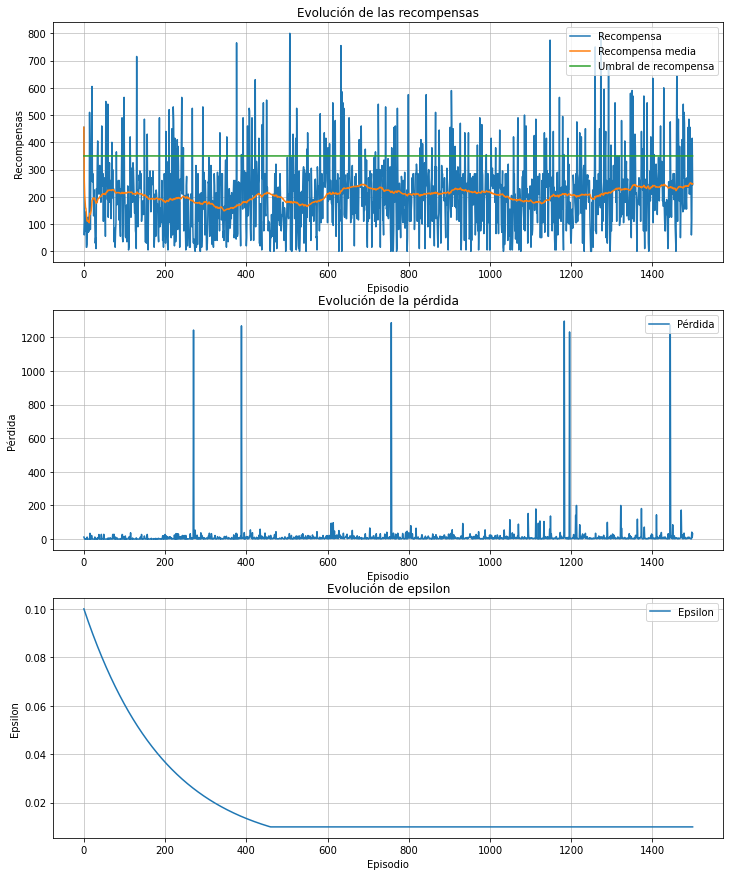

In [28]:
episode = list(range(0, max_episodes))
train_rewards = DQN_Agent.train_rewards
train_mean_rewards = DQN_Agent.train_mean_rewards
train_loss = DQN_Agent.train_loss
reward_threshold = DQN_Agent.reward_threshold*np.ones(max_episodes)
eps_evolution = DQN_Agent.eps_evolution

fig, axes = plt.subplots(3, 1, figsize=(12, 15))
ax = axes.ravel()
ax[0].plot(episode, train_rewards, label = 'Recompensa')
ax[0].plot(episode, train_mean_rewards, label = 'Recompensa media')
ax[0].plot(episode, reward_threshold, label = 'Umbral de recompensa')
ax[0].grid(axis='both', alpha=0.75)
ax[0].set_title('Evolución de las recompensas')
ax[0].set_xlabel('Episodio')
ax[0].set_ylabel('Recompensas')
ax[0].legend(loc='upper right')
ax[1].plot(episode, train_loss, label = 'Pérdida')
ax[1].grid(axis='both', alpha=0.75)
ax[1].set_title('Evolución de la pérdida')
ax[1].set_xlabel('Episodio')
ax[1].set_ylabel('Pérdida')
ax[1].legend(loc='upper right')
ax[2].plot(episode, eps_evolution, label = 'Epsilon')
ax[2].grid(axis='both', alpha=0.75)
ax[2].set_title('Evolución de epsilon')
ax[2].set_xlabel('Episodio')
ax[2].set_ylabel('Epsilon')
ax[2].legend(loc='upper right')

In [29]:
from numpy import savetxt
from numpy import loadtxt

# Guardamos la media de recompensas del modelo en un CSV
savetxt('mean_rewards_DQN_model.csv', train_mean_rewards, delimiter=',')
mean_rewards_DQN_model = loadtxt('mean_rewards_DQN_model.csv', delimiter=',')

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Ejercicio 2.10 (0.1 ptos):</strong> Comenta los resultados
</div>

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Solución:</strong>

Como podemos observar, en un primer momento la recompensa media ha sido muy alta, suponemos que por casualidad.
Parece que el agente va aprediendo a medida que juega hasta el episodio 700 aproximadamente, aunque con muchos vaivenes.
Permanece entorno a los 200 puntos de media, sin bajar de 100 ni superar los 300, no consiguiendo acercarse al umbral de 350.
    
Podemos ver cómo hay algunos picos enormes en la pérdida, quedando en general bastante baja, y como a medida que avanza el entrenamiento se ven pérdidas comparativamente más altas.
    
Por otro lado, la evolución de epsilon es gradual, como queríamos, hasta que alrededor del episodio 450 alcanza el mínimo de 0.01, y permance estable hasta el final del entrenamiento.
</div>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Ejercicio 2.11 (0.1 pto):</strong> Guardar el modelo entrenado en formato ".pth".
</div>

In [30]:
# Guardamos el modelo entrenado en formato .pth
torch.save(main_network.state_dict(), "DQN_CNN_Model.pth")

### 2.4 Test del agente entrenado

Una vez entrenado el agente, nos interesa comprobar cómo de bien ha aprendido, si el "robot" es capaz de realizar las tareas aprendidas. Para ello, recuperamos el modelo entrenado y dejamos que el agente tome acciones según ese modelo y observamos su comportamiento.



<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 2.12 (0.2 pto):</strong> Cargar el modelo entrenado y ejecutar el agente entrenado durante 20 episodios consecutivos. Calcular la suma de recompensas para cada episodio. Mostrar en un gráfico la suma de las recompensas respecto de los episodios, incluyendo el umbral de recompensa establecido por el entorno.

</div>

In [31]:
# Creamos una función para ejecutar el agente
##TODO: Calcular la suma de recompensas
def agent_test(agent, episodes):
    
    for i in range(episodes):
        state = env.reset()
        state0 = stack_frame(None, preprocess_observation(state), True)
        total_reward = 0
        t=0
        done = False
        
        while not done:
            action = agent.main_network.get_action(state0, epsilon=0.0)
            new_state, reward, done, _ = env.step(action)
            new_state = stack_frame(state0, preprocess_observation(new_state), False)
            state0 = new_state
            total_reward += reward
            t=t+1

        env.close()
        rewards.append(total_reward)
    
    return rewards

In [32]:
# Cargamos el modelo y mostramos la estructura
main_network.load_state_dict(torch.load("DQN_CNN_Model.pth"))
main_network.eval()

DQN_CNN(
  (red_cnn): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
  )
  (red_lineal): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=6, bias=True)
  )
)

In [33]:
env = gym.make('SpaceInvaders-v4')

episodes = 20
episode = list(range(0, episodes))
agent_reward_threshold = DQN_Agent.reward_threshold*np.ones(episodes)
rewards = []

rewards = agent_test(DQN_Agent, episodes)

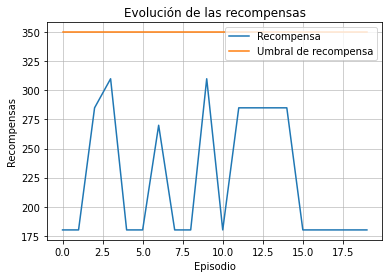

In [34]:
plt.plot(episode, rewards, label = 'Recompensa')
plt.plot(episode, agent_reward_threshold, label = 'Umbral de recompensa')
plt.grid(axis='both', alpha=0.75)
plt.title('Evolución de las recompensas')
plt.xlabel('Episodio')
plt.ylabel('Recompensas')
plt.legend(loc='upper right')
plt.show()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis 2.13 (0.1 pto):</strong> Almacena una partida de ejemplo del agente en la carpeta videos en formato GIF para poder visualizar su comportamiento (se da el código hecho) y comenta el comportamiento del agente entrenado.
</div>

In [ ]:
env = gym.make('SpaceInvaders-v4', render_mode='rgb_array')

def save_agent_gif(env, ag, nombre_fichero):
    '''
    :param env:  entorno GYM
    :param ag:  agente entrenado
    :param nombre_fichero:  nombre del fichero
    :return:
    '''
    frames = []
    env.reset()
    observation = env.reset()
    inicio_juego = preprocess_observation(observation)
    state= stack_frame(None, inicio_juego, True)
    total_reward = 0
    t=0
    
    while True:
            state= stack_frame(state, preprocess_observation(observation), False)
            frame = env.render(mode='rgb_array')
            frames.append(_label_with_text(frame))
            action = ag.main_network.get_action(state,epsilon=0.0)
            observation, reward, done, info = env.step(action)
            total_reward += reward
            t=t+1
            if done:
                break

    env.close()
    
    try:
        os.makedirs('videos')
    except:
        pass
    
    imageio.mimwrite(os.path.join('./videos/', nombre_fichero), frames, fps=60)

save_agent_gif(env,DQN_Agent, 'agente_dqn.gif')

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Respuesta:</strong>
<br>
Podemos ver que en las 20 partidas jugadas con el agente entrenado en ningún momento hemos alcanzado el umbral de 350, aunque sí que se han superado los 300 puntos en algunas ocasiones.
    
Con respecto al gif, en nuestro caso el agente se mueve por la zona izquierda de la pantalla, protegiéndose con los escudos naranjas en algunos casos, y disparando todo lo que puede (incluso a los propios escudos). No es un comportamiento óptimo pero sí parece que parece haber aprendido a lo largo del entrenamiento.
<br>

</div>


Puede ser que el resultado sea muy parecido al siguiente GIF. No os preocupéis, con los parámetros escogidos es difícil obtener unos mejores resultados.
![title](videos/space_invader_dqn_comportamiento_continuo.gif)